# Exploratory Data Analysis of Pneumothorax dataset

------------------

# Hi Or ! please see this notebook before you see what i did here: eda-of-pneumothorax-dataset

# generaly i took that, changed code, added or changed some plots, and this can be all the EDA possible. i looked at a few other notebooks - they dont seem as good as this one, but you are more than welcomed to check it out !!!

------------------

## Preparations

### Imports

In [1]:
# Data handling imports
import pandas as pd
pd.reset_option('max_colwidth')
import numpy as np

# Read DICOM format
import pydicom

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# General purpose imports
import os
from glob import glob

# Benchmark \ Baseline U-net
# pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

### Set Paths

In [2]:
# general folder path
user = 'or' # 'or' \ 'roy'
if user == 'roy':
    # I downloaded the data from: 'https://www.kaggle.com/datasets/seesee/siim-train-test'
    folder_path = '/Users/royrubin/Downloads/siim/' 
else:
    folder_path = '... OR - your path'
    
# paths for files
train_rle_encodings_file_path = os.path.join(folder_path, 'train-rle.csv')
train_files_path = os.path.join(folder_path, 'dicom-images-train/')
test_files_path = os.path.join(folder_path, 'dicom-images-test/')

print(f'train_rle_encodings_file_path: {train_rle_encodings_file_path}')
print(f'train_files_path: {train_files_path}')
print(f'test_files_path: {test_files_path}')

train_rle_encodings_file_path: ... OR - your path\train-rle.csv
train_files_path: ... OR - your path\dicom-images-train/
test_files_path: ... OR - your path\dicom-images-test/


### Handle uncomfotable and uneeded subdirs

In [3]:
#reading all dcm files into train and text
if user in  'roy':
    # I downloaded the data from: 'https://www.kaggle.com/datasets/seesee/siim-train-test'
    train_file_names = sorted(glob(train_files_path + "*/*/*.dcm"))
    test_file_names = sorted(glob(test_files_path + "*/*/*.dcm")) # sorted([f for f in listdir(test_files_path) if '.dcm' in f])
else:
    # I downloaded the data from: 'https://www.kaggle.com/datasets/seesee/siim-train-test'
    train_file_names = sorted(glob(train_files_path + "*/*/*.dcm"))
    test_file_names = sorted(glob(test_files_path + "*/*/*.dcm")) # sorted([f for f in listdir(test_files_path) if '.dcm' in f])
    
print(f"\ntrain files: amount {len(train_file_names)}, examples: \n{train_file_names[0]}\n{train_file_names[1]}")
print(f"\ntest files: amount {len(test_file_names)}, examples: \n{test_file_names[0]}\n{test_file_names[1]}")

IndexError: list index out of range

### Read the RLE encondings csv

In [4]:
%%time
# read train-rle.csv
train_rle_encodings_df = pd.read_csv(train_rle_encodings_file_path, delimiter=",")
train_rle_encodings_df.rename(columns={" EncodedPixels": "EncodedPixels"}, inplace=True)

CPU times: user 73 ms, sys: 19.6 ms, total: 92.6 ms
Wall time: 138 ms


In [5]:
print(f'size {train_rle_encodings_df.shape}')
train_rle_encodings_df.head(3)

size (12954, 2)


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1


### Read images train data from DICOM format

In [6]:
%%time
# around 3 mins
temp = [{'UID': pydicom.read_file(file_name).SOPInstanceUID, 'Image': pydicom.read_file(file_name).pixel_array} 
                for file_name in train_file_names]
train_images_df = pd.DataFrame(temp)

CPU times: user 1min 50s, sys: 15 s, total: 2min 5s
Wall time: 2min 35s


In [7]:
print(f'size {len(train_images_df)}')
print(f'shape of single image {train_images_df.iloc[0].Image.shape}')
train_images_df.head(3)

size 12089
shape of single image (1024, 1024)


,UID,Image
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,"[[78, 81, 81, 81, 82, 82, 84, 90, 92, 95, 87, ..."
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,"[[4, 8, 7, 6, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5,..."


### Read metadata train data from DICOM format

In [8]:
%%time
# around 30 secs
train_metadata = [pydicom.dcmread(file_name) for file_name in train_file_names]

CPU times: user 18.1 s, sys: 5.94 s, total: 24.1 s
Wall time: 36.9 s


In [9]:
print(type(train_metadata[0]))

<class 'pydicom.dataset.FileDataset'>


### Function for viewing single patient data extracted from pydicom format

In [10]:
def show_patient_data(patient_file_name: str):
    #displaying metadata
    data = pydicom.dcmread(patient_file_name)
    print(data)
    
    #displaying the image
    img = pydicom.read_file(patient_file_name).pixel_array
    plt.figure(0)
    plt.grid(False)
    plt.imshow(img, cmap='bone')

### Function for generating metadata pandas dataframe

In [11]:
def generate_metadata_dataframe(train_metadata: list, masks: pd.DataFrame):
    
    patients = pd.DataFrame()

    for data in train_metadata:
        patient = dict()
        
        # save the wanted features from the dicom foramt
        patient["UID"] = data.SOPInstanceUID
        patient["PatientID"] = data.PatientID        
        patient["Age"] = data.PatientAge
        patient["Sex"] = data.PatientSex
        patient["Modality"] = data.Modality
        patient["BodyPart"] = data.BodyPartExamined
        patient["ViewPosition"] = data.ViewPosition
        patient["Columns"] = data.Columns
        patient["Rows"] = data.Rows
        patient["PatientOrientation"] = data.PatientOrientation
        patient["PhotometricInterpretation"] = data.PhotometricInterpretation
        patient["PixelSpacing"] = data.PixelSpacing
        patient["SamplesPerPixel"] = data.SamplesPerPixel
        patient["PixelSpacing"] = data.PixelSpacing

        # add a label to the data - if the patient has the disease or not
        try:
            encoded_pixels = masks[masks["ImageId"] == patient["UID"]].values[0][1]
            # patient["EncodedPixels"] = encoded_pixels
            patient["Label"] = 'Healthy' if encoded_pixels == '-1' else 'Pneumothorax'
        except:
            patient["Label"] = 'NoLabel'
            
#         # multiple labels ???
#         patient["Multiple"] = False
#         tmp = masks[masks['ImageId'] == '.'.join(patient["UID"].split('.')[:-1])]
        
#         if tmp.shape[0] > 1: 
#             patient["Multiple"] = True
        
        # finally
        patients = patients.append(patient, ignore_index=True)
    
    # return the dataframe as output
    return patients

In [12]:
%%time
# around 3 mins
train_metadata_df = generate_metadata_dataframe(train_metadata, train_rle_encodings_df)

CPU times: user 1min 34s, sys: 2.05 s, total: 1min 36s
Wall time: 1min 55s


#### what does the data look like ?

In [13]:
train_rle_encodings_df.iloc[0]

ImageId          1.2.276.0.7230010.3.1.4.8323329.6904.151787520...
EncodedPixels                                                   -1
Name: 0, dtype: object

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

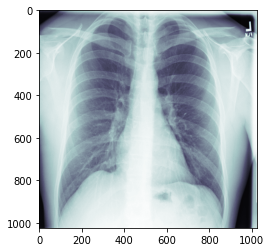

In [14]:
show_patient_data(train_file_names[0])


<br> </br>
## EDA on the Train data !
<br> </br>


### Step 1: Meta Data EDA

#### Step 1.1: General exploration

In [15]:
train_metadata_df.shape

(12089, 14)

In [16]:
train_metadata_df.head(3)

,UID,PatientID,Age,Sex,Modality,BodyPart,ViewPosition,Columns,Rows,PatientOrientation,PhotometricInterpretation,PixelSpacing,SamplesPerPixel,Label
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,17d405a3-a0d2-4901-b33a-63906aa48d9f,38,M,CR,CHEST,PA,1024.0,1024.0,,MONOCHROME2,"[0.168, 0.168]",1.0,Healthy
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,8ab1ffda-8b65-4914-95d6-2e549e328666,10,F,CR,CHEST,AP,1024.0,1024.0,,MONOCHROME2,"[0.139, 0.139]",1.0,Healthy
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,bfef51d3-6541-4792-bac1-d21d41ee60fd,50,F,CR,CHEST,AP,1024.0,1024.0,,MONOCHROME2,"[0.168, 0.168]",1.0,Healthy


In [17]:
train_metadata_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12089 entries, 0 to 12088
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   UID                        12089 non-null  object 
 1   PatientID                  12089 non-null  object 
 2   Age                        12089 non-null  object 
 3   Sex                        12089 non-null  object 
 4   Modality                   12089 non-null  object 
 5   BodyPart                   12089 non-null  object 
 6   ViewPosition               12089 non-null  object 
 7   Columns                    12089 non-null  float64
 8   Rows                       12089 non-null  float64
 9   PatientOrientation         12089 non-null  object 
 10  PhotometricInterpretation  12089 non-null  object 
 11  PixelSpacing               12089 non-null  object 
 12  SamplesPerPixel            12089 non-null  float64
 13  Label                      12089 non-null  obj

In [18]:
#### We can see that age here is an object and not an int (or float). we'll convert it to int

In [19]:
train_metadata_df['Age'] = train_metadata_df['Age'].astype(str).astype(int)

In [20]:
train_metadata_df.describe(include='all')

,UID,PatientID,Age,Sex,Modality,BodyPart,ViewPosition,Columns,Rows,PatientOrientation,PhotometricInterpretation,PixelSpacing,SamplesPerPixel,Label
count,12089,12089,12089.000000,12089,12089,12089,12089,12089.0,12089.0,12089,12089,12089,12089.0,12089
unique,12089,12089,NaN,2,1,1,2,NaN,NaN,1,1,11,NaN,3
top,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,17d405a3-a0d2-4901-b33a-63906aa48d9f,NaN,M,CR,CHEST,PA,NaN,NaN,,MONOCHROME2,"[0.14300000000000002, 0.14300000000000002]",NaN,Healthy
freq,1,1,NaN,6650,12089,12089,7290,NaN,NaN,12089,12089,4433,NaN,9378
mean,NaN,NaN,46.987178,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,1.0,NaN
std,NaN,NaN,17.091074,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,1.0,NaN
25%,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,1.0,NaN
50%,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,1.0,NaN
75%,NaN,NaN,59.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,1.0,NaN


#### After seeing the stats above, some information can be dropped.
* 'Modality' is always CR (Computed Radiography)
* 'BodyPart' is always CHEST
* 'PatientOrientation' is always empty
* 'PhotometricInterpretation' is always MONOCHROME2
* 'SamplesPerPixel' is always 1
* 'Columns' and 'Rows' are always 1024
* 'Age' contains values that are illegal <-----------

In [21]:
list_of_columns_to_drop = ['Modality','BodyPart','PatientOrientation','PhotometricInterpretation','SamplesPerPixel', 'Columns', 'Rows']
train_metadata_df.drop(columns=list_of_columns_to_drop, inplace=True, errors='ignore')
train_metadata_df.drop(train_metadata_df[train_metadata_df.Age > 120].index, inplace=True)
print(f'dropped {len(list_of_columns_to_drop)} columns')
print(f'dropped {len(train_metadata_df[train_metadata_df.Age > 120].index)} rows')

dropped 7 columns
dropped 0 rows


In [22]:
train_metadata_df.shape

(12087, 7)

In [23]:
train_metadata_df.head(3)

,UID,PatientID,Age,Sex,ViewPosition,PixelSpacing,Label
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,17d405a3-a0d2-4901-b33a-63906aa48d9f,38,M,PA,"[0.168, 0.168]",Healthy
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,8ab1ffda-8b65-4914-95d6-2e549e328666,10,F,AP,"[0.139, 0.139]",Healthy
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,bfef51d3-6541-4792-bac1-d21d41ee60fd,50,F,AP,"[0.168, 0.168]",Healthy


#### Check for unique values and their counts in the metadata

In [24]:
for column in list(train_metadata_df.columns):
    if 'ID' not in column and 'EncodedPixels' not in column:
        counts = train_metadata_df[column].value_counts()
        print(f'\nNumber of unique values in column [{column}]: {len(counts)}, Value counts:\n{counts}\n--------------')


Number of unique values in column [Age]: 91, Value counts:
58    368
57    315
51    303
55    295
56    291
     ... 
84      2
88      2
94      1
90      1
1       1
Name: Age, Length: 91, dtype: int64
--------------

Number of unique values in column [Sex]: 2, Value counts:
M    6649
F    5438
Name: Sex, dtype: int64
--------------

Number of unique values in column [ViewPosition]: 2, Value counts:
PA    7289
AP    4798
Name: ViewPosition, dtype: int64
--------------

Number of unique values in column [PixelSpacing]: 11, Value counts:
[0.14300000000000002, 0.14300000000000002]    4432
[0.168, 0.168]                                3681
[0.139, 0.139]                                2258
[0.171, 0.171]                                 891
[0.19431099999999998, 0.19431099999999998]     791
[0.19431400000000001, 0.19431400000000001]      16
[0.19430799999999998, 0.19430799999999998]      12
[0.115, 0.115]                                   2
[0.19378399999999998, 0.19378399999999998]    

#### Gender analysis

In [25]:
men = train_metadata_df[train_metadata_df["Sex"] == "M"].shape[0]
women = train_metadata_df[train_metadata_df["Sex"] == "F"].shape[0]

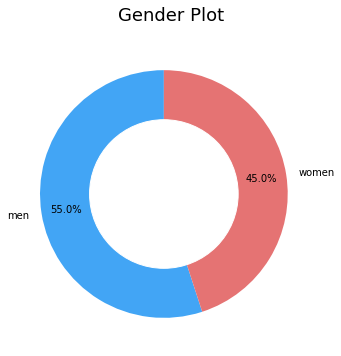

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle("Gender Plot", fontsize=18)
circle0 = plt.Circle( (0,0), 0.6, color = 'white')
ax.pie([men, women], labels=["men", "women"], colors=["#42A5F5", "#E57373"], autopct='%1.1f%%', pctdistance=0.8, startangle=90)
ax.add_patch(circle0)
plt.tight_layout()
plt.show()

#### Illness Analysis

In [27]:
healthy = train_metadata_df[train_metadata_df["Label"] == "Healthy"].shape[0]
ill = train_metadata_df[train_metadata_df["Label"] == "Pneumothorax"].shape[0]

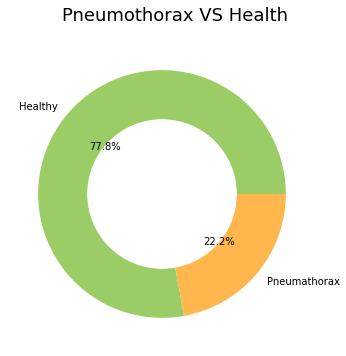

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle("Pneumothorax VS Health", fontsize=18)
circle1 = plt.Circle( (0,0), 0.6, color = 'white')

ax.pie([healthy, ill], labels=["Healthy", "Pneumathorax"], colors=["#9CCC65", "#FFB74D"], autopct='%1.1f%%')
ax.add_patch(circle1)

plt.tight_layout()
plt.show()

#### Gender & Illness Analysis

In [29]:
men_h = train_metadata_df[(train_metadata_df["Sex"] == "M") & (train_metadata_df["Label"] == "Healthy")].shape[0]
men_ill = men - men_h
women_h = train_metadata_df[(train_metadata_df["Sex"] == "F") & (train_metadata_df["Label"] == "Healthy")].shape[0]
women_ill = women - women_h

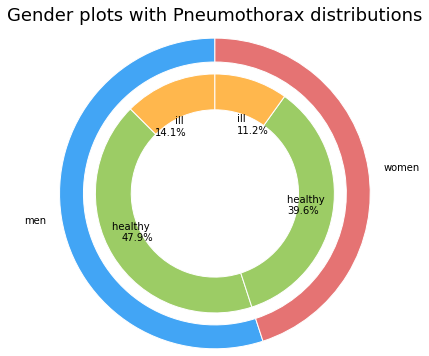

In [30]:
perc = ["ill \n" + str(round(men_ill/107.12, 1)) + "%", 
        "healthy \n" + str(round(men_h/107.12, 1)) + "%", 
        "healthy \n" + str(round(women_h/107.12, 1)) + "%",
        "ill \n" + str(round(women_ill/107.12, 1)) + "%"]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

fig.suptitle("Gender plots with Pneumothorax distributions", fontsize=18)

mypie, _ = ax.pie([men, women], radius=1.3, labels=["men", "women"], colors=["#42A5F5", "#E57373"], startangle=90)
plt.setp( mypie, width=0.2, edgecolor='white')

mypie2, _ = ax.pie([ men_ill, men_h, women_h, women_ill], radius = 1.3 - 0.3, labels=perc, labeldistance=0.61,
                      colors = ["#FFB74D", "#9CCC65", "#9CCC65", "#FFB74D"], startangle=90)
plt.setp( mypie2, width=0.3, edgecolor='white')

plt.tight_layout()
plt.show()

#### Age Analysis

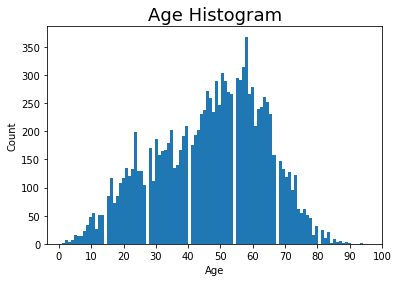

In [31]:
plt.figure()
train_metadata_df["Age"].plot.hist(bins = 100)
plt.title("Age Histogram", fontsize=18)
plt.xlabel("Age")
plt.xticks([i*10 for i in range(11)])
plt.ylabel("Count")
plt.show()

/Users/royrubin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


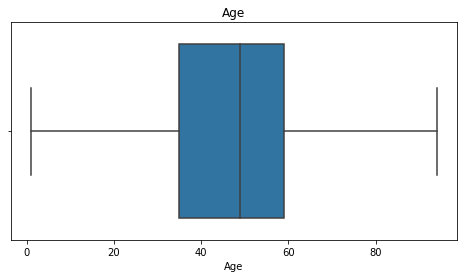

In [32]:
train_metadata_df['Age'] = train_metadata_df['Age'].astype('int') 
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,4))
sns.boxplot(train_metadata_df['Age'])
axes.title.set_text(f'Age')
plt.show()

#### Age & Illness Analysis

In [33]:
bins = [i for i in range(100)]

all_men = np.histogram(train_metadata_df[train_metadata_df["Sex"] == "M"]["Age"].values, bins=bins)[0]
all_women = np.histogram(train_metadata_df[train_metadata_df["Sex"] == "F"]["Age"].values, bins=bins)[0]

ill_men = np.histogram(train_metadata_df[(train_metadata_df["Sex"] == "M") & (train_metadata_df["Label"] != 'Healthy')]["Age"].values, bins=bins)[0]
ill_women = np.histogram(train_metadata_df[(train_metadata_df["Sex"] == "F") & (train_metadata_df["Label"] != 'Healthy')]["Age"].values, bins=bins)[0]

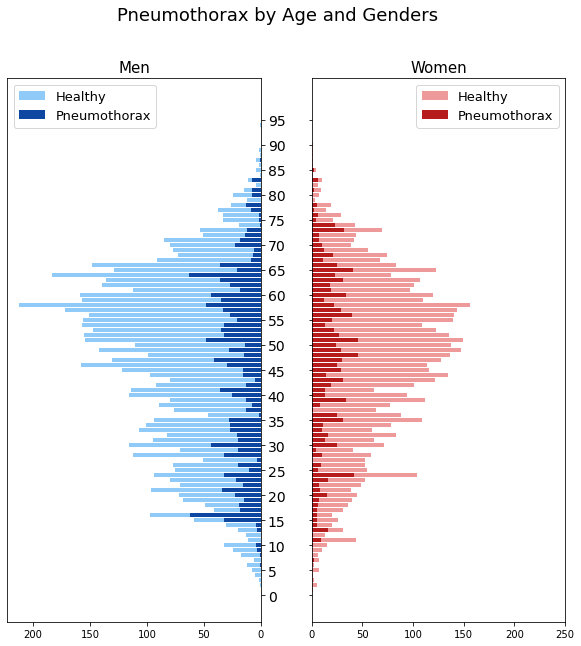

In [34]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 10))
fig.suptitle("Pneumothorax by Age and Genders", fontsize=18)

# Men plot
# axes[0].margins(x=0.1, y=0.01)
m1 = axes[0].barh(bins[:-1], all_men, color='#90CAF9')
m2 = axes[0].barh(bins[:-1], ill_men, color='#0D47A1')
axes[0].set_title('Men', fontsize=15)
axes[0].invert_xaxis()
axes[0].set(yticks=[i*5 for i in range(20)])
axes[0].tick_params(axis="y", labelsize=14)
axes[0].yaxis.tick_right()
# axes[0].xaxis.tick_top()
axes[0].legend((m1[0], m2[0]), ('Healthy', 'Pneumothorax'), loc=2, prop={'size': 13})

# Women plot
# axes[1].margins(y=0.01)
w1 = axes[1].barh(bins[:-1], all_women, color='#EF9A9A')
w2 = axes[1].barh(bins[:-1], ill_women, color='#B71C1C')
axes[1].set_title('Women', fontsize=15)
# axes[1].xaxis.tick_top()
axes[1].legend((w1[0], w2[0]), ('Healthy', 'Pneumothorax'), prop={'size': 13})

# adjust
locs = axes[0].get_xticks()
axes[1].set_xticks(locs)

plt.show()

#### View Positions

The view position can be AP or PA. These refer to the way of x-ray in the body, [based on this source](https://www.quora.com/What-is-the-difference-between-an-AP-and-a-PA-view-of-an-X-ray)
* PA: passes from posterior of the body to anterior --> getting better anterior shadings
* AP: passes from anterior of the body to posterior --> getting better posterior shaginds

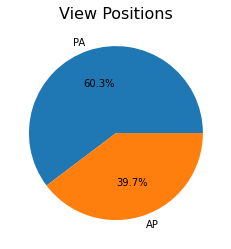

In [35]:
plt.figure()
plt.pie(train_metadata_df["ViewPosition"].value_counts(), labels = ["PA", "AP"], autopct='%1.1f%%') 
plt.title("View Positions", fontsize=16)
plt.show()

/Users/royrubin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 87.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/royrubin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 82.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/royrubin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 65.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/royrubin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 44.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


CPU times: user 57.9 s, sys: 616 ms, total: 58.6 s
Wall time: 1min 1s


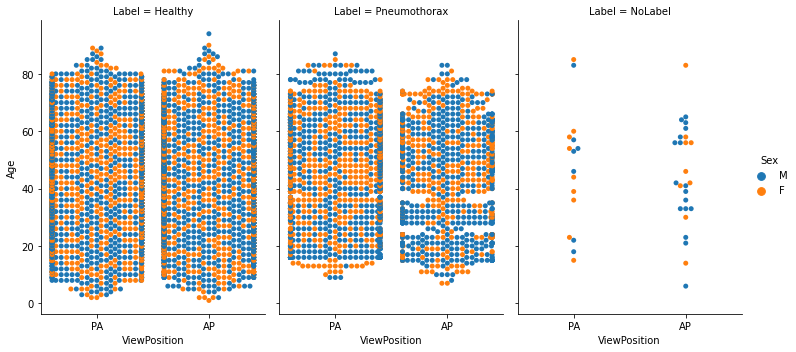

In [36]:
%%time
sns.catplot(x="ViewPosition", y="Age", hue="Sex",
            col="Label", aspect=.7,
            kind="swarm", data=train_metadata_df)

<AxesSubplot:xlabel='ViewPosition', ylabel='count'>

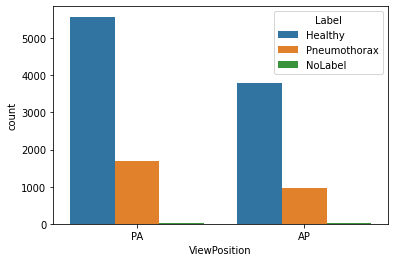

In [37]:
sns.countplot(x="ViewPosition", hue='Label', data=train_metadata_df)

## Masks EDA

In [38]:
train_rle_encodings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12954 entries, 0 to 12953
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        12954 non-null  object
 1   EncodedPixels  12954 non-null  object
dtypes: object(2)
memory usage: 202.5+ KB


In [39]:
train_rle_encodings_df.describe(include='all')

,ImageId,EncodedPixels
count,12954,12954
unique,12047,3577
top,1.2.276.0.7230010.3.1.4.8323329.1851.151787516...,-1
freq,10,9378


#### note from the above that some images have more than one mask !

<div class="alert alert-block alert-warning">
<b>Note:</b> some images have multiple masks. solution: the masks are joind together (see below)
</div>

#### generate more information on the masks

In [40]:
# Copied from Kaggle "mask_functions.py"
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [41]:
def get_image_by_uid(images_df, uid):
    image = images_df[images_df.UID == uid].Image.item() # item is added because the result is a series object with 1 element
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

In [42]:
def get_mask_by_uid(rle_encodings_df, image, uid):
    # create the mask 
    # note: there can be more than one RLE encoding per image
    rle_encodings = rle_encodings_df[rle_encodings_df.ImageId == uid].EncodedPixels   
    final_mask = None
    for rle_encoding in rle_encodings.to_list():
        current_mask = rle2mask(rle=rle_encoding, width=image.shape[0], height=image.shape[1])
        if final_mask is None:
            final_mask = current_mask
        else:
            # print(f'another mask is added')
            final_mask += current_mask  # Important logic

    # mask needs to be rotated to fit the original image
    mask = final_mask
    mask = np.rot90(mask, 3) #rotating three times 90 to the right place
    mask = np.flip(mask, axis=1)
    
    return mask

In [43]:
def get_total_area_of_and_metadata_of_masks(metadata_df, images_df, rle_encodings_df):
    """
    important note: if there are multiple notes for each image, we use the sum of these masks
    
    note: the result does not only give the area, but also some metadata for plotting later on
    """
    result = []
    for _, row in metadata_df.iterrows():
        # prepare data for plots
        try:
            uid = row['UID']
            image = get_image_by_uid(images_df, uid)
            mask = get_mask_by_uid(rle_encodings_df, image, uid)
            pixels = np.count_nonzero(mask)
            
            # save results with additional metadata on the mask and image
            result.append(
                {
                    'TotalArea': pixels, 
                    'ViewPosition': row['ViewPosition'], 
                    'Sex': row['Sex'], 
                    'Age': row['Age'],
                    'Mask': mask,  # get the mask itself for later on when we will create heatmaps
                })
        except Exception as e:
            raise e
            print(f'could not process image with uid {uid}.\nreason: {e}')
            continue
            
    return result

In [44]:
%%time
# around 1 min

train_metadata_df_ill = train_metadata_df[train_metadata_df['Label'] == 'Pneumothorax'].reset_index(drop=True)

results = get_total_area_of_and_metadata_of_masks(
    metadata_df=train_metadata_df_ill, 
    images_df=train_images_df, 
    rle_encodings_df=train_rle_encodings_df
)

CPU times: user 32.1 s, sys: 25.5 s, total: 57.6 s
Wall time: 1min 4s


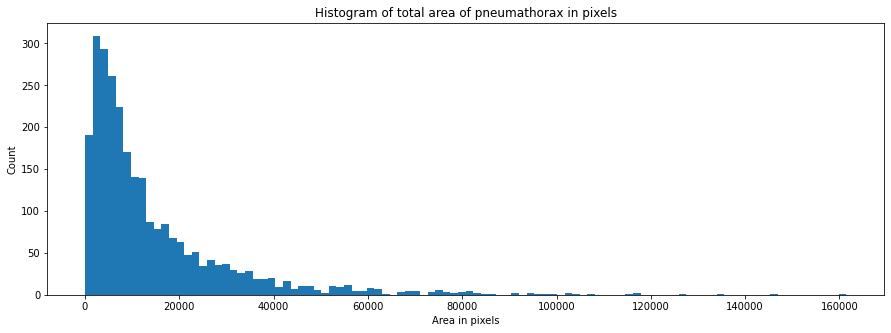

In [45]:
list_of_areas = [list_item['TotalArea'] for list_item in results] 
plt.figure(figsize=(15, 5))
plt.title(f'Histogram of total area of pneumathorax in pixels')
plt.hist(list_of_areas, bins = 100)
plt.xlabel("Area in pixels")
plt.ylabel("Count")
plt.show()

Remember: ~60% of train data are PA


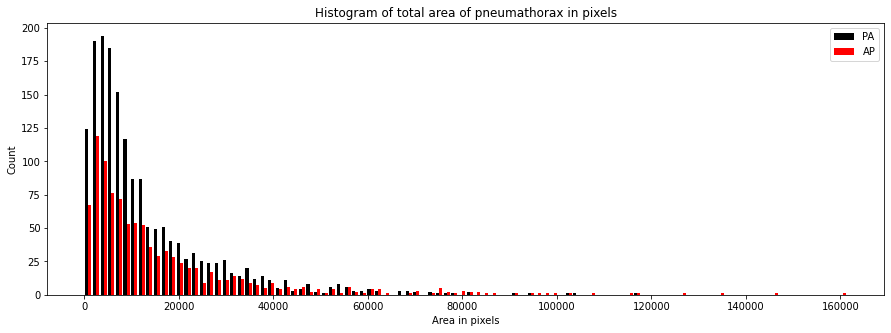

In [46]:
print(f'Remember: ~60% of train data are PA')
list_of_areas_pa = [list_item['TotalArea'] for list_item in results if list_item['ViewPosition'] == 'PA'] 
list_of_areas_ap = [list_item['TotalArea'] for list_item in results if list_item['ViewPosition'] == 'AP'] 
plt.figure(figsize=(15, 5))
plt.title(f'Histogram of total area of pneumathorax in pixels')
plt.hist([list_of_areas_pa, list_of_areas_ap], color=['Black', 'Red'], label=['PA', 'AP'], bins = 100)
plt.xlabel("Area in pixels")
plt.ylabel("Count")
plt.legend()
plt.show()

Remember: ~55% of train data are male


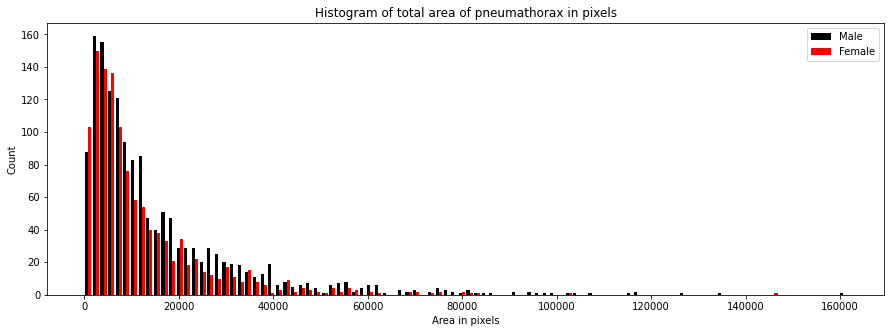

In [47]:
print(f'Remember: ~55% of train data are male')
list_of_areas_male = [list_item['TotalArea'] for list_item in results if list_item['Sex'] == 'M'] 
list_of_areas_female = [list_item['TotalArea'] for list_item in results if list_item['Sex'] == 'F'] 
plt.figure(figsize=(15, 5))
plt.title(f'Histogram of total area of pneumathorax in pixels')
plt.hist([list_of_areas_male, list_of_areas_female], color=['Black', 'Red'], label=['Male', 'Female'], bins = 100)
plt.xlabel("Area in pixels")
plt.ylabel("Count")
plt.legend()
plt.show()

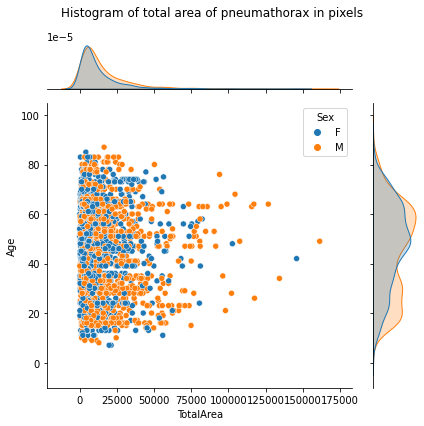

In [48]:
temp_df = pd.DataFrame(results)

ax = sns.jointplot(data=temp_df, x="TotalArea", y="Age", hue="Sex")
ax.fig.suptitle('Histogram of total area of pneumathorax in pixels')
ax.fig.tight_layout()
plt.show()

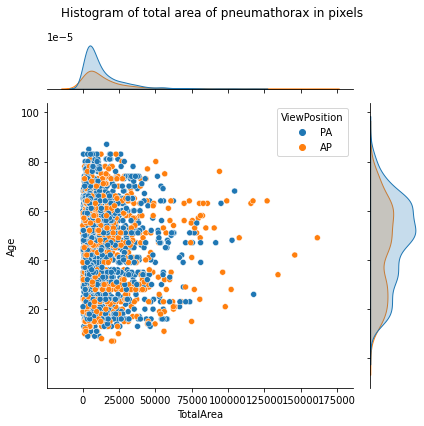

In [49]:
ax = sns.jointplot(data=temp_df, x="TotalArea", y="Age", hue="ViewPosition")
ax.fig.suptitle('Histogram of total area of pneumathorax in pixels')
ax.fig.tight_layout()
plt.show()

## Images + Masks EDA

In [50]:
def get_bounding_box(img):
    # return max and min of a mask to draw bounding box
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    return rmin, cmin, rmax, cmax #ymin,xmin,ymax,cmax

In [51]:
def plot_imgs(uids_list, images_df, rle_encodings_df):
    for uid in uids_list:
        # prepare data for plots
        try:
            image = get_image_by_uid(images_df, uid)
            mask = get_mask_by_uid(rle_encodings_df, image, uid)
            rmin, cmin, rmax, cmax = get_bounding_box(mask)
        except Exception as e:
            raise e
            print(f'could not process image with uid {uid}.\nreason: {e}')
            continue
        
        # Create the figure
        fig, axes = plt.subplots(1,4, figsize=(20,15))
        
        # Create the plot for the original image
        axes[0].imshow(image, cmap='bone')
        axes[0].set_title('Original Image')
        
        # Create the plot for the Pneumathorax mask
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Mask Only')
        
        # Create the plot for the original image with the mask on top of it
        axes[2].imshow(image, cmap='bone')
        axes[2].imshow(mask, alpha=0.3,cmap='Reds')
        axes[2].set_title('Image + mask')
        
        # Create the plot for original image +mask+ mask bounding box
        cv2.rectangle(image, (cmin,rmin),(cmax,rmax), (255,255,0), 5)
        axes[3].imshow(image)
        axes[3].imshow(mask,alpha=0.3,cmap='Reds')
        axes[3].set_title('Image + Mask + Bounding Box')
        
        # Finally, show image
        plt.show()

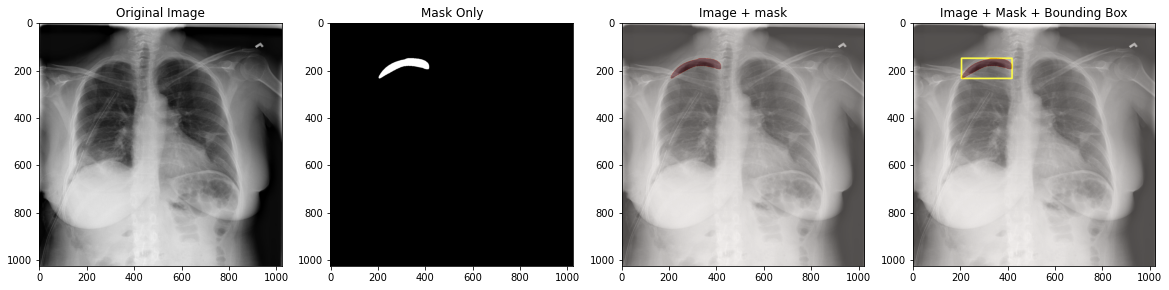

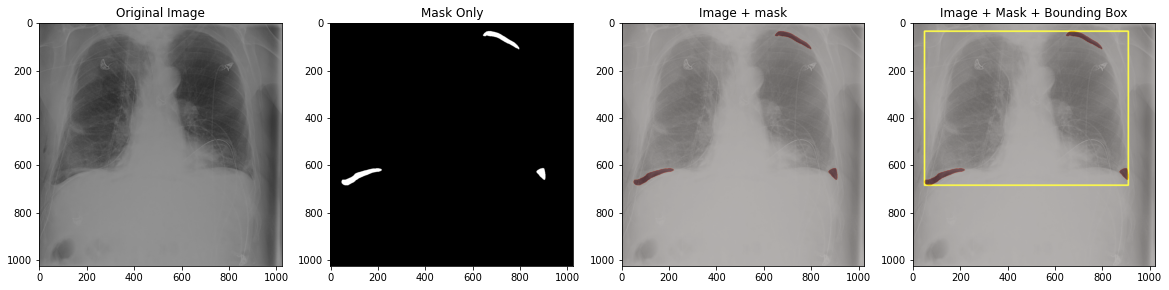

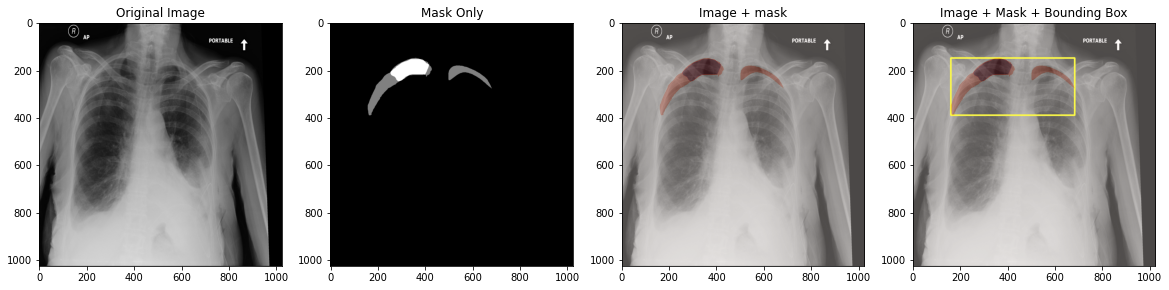

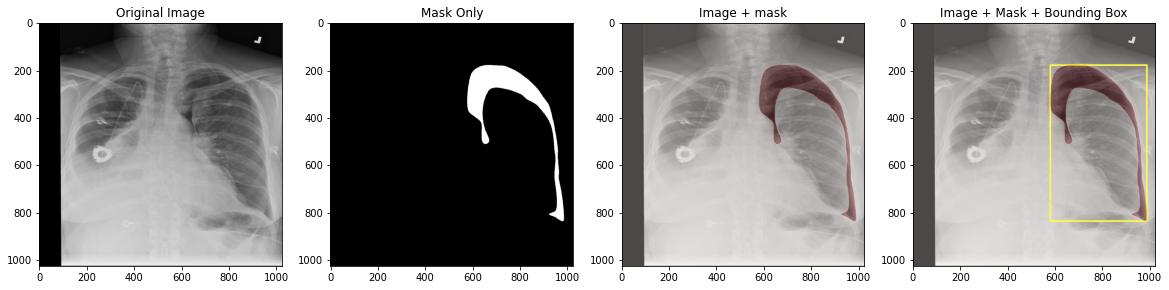

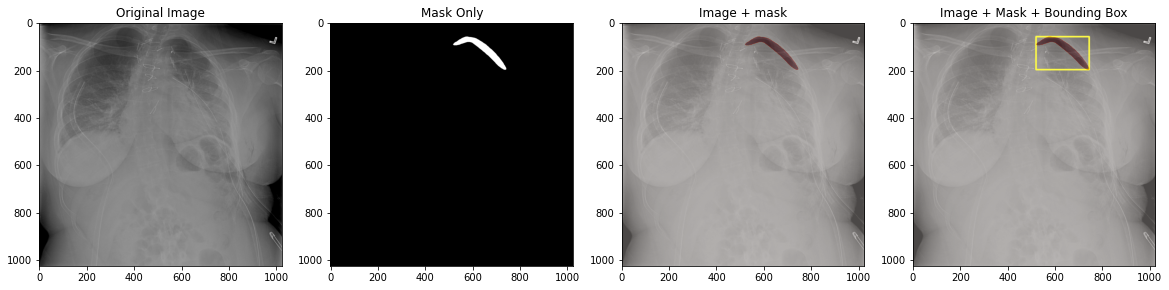

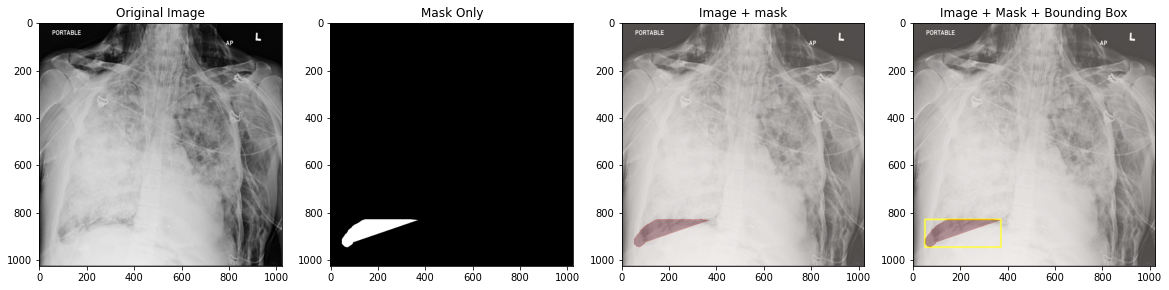

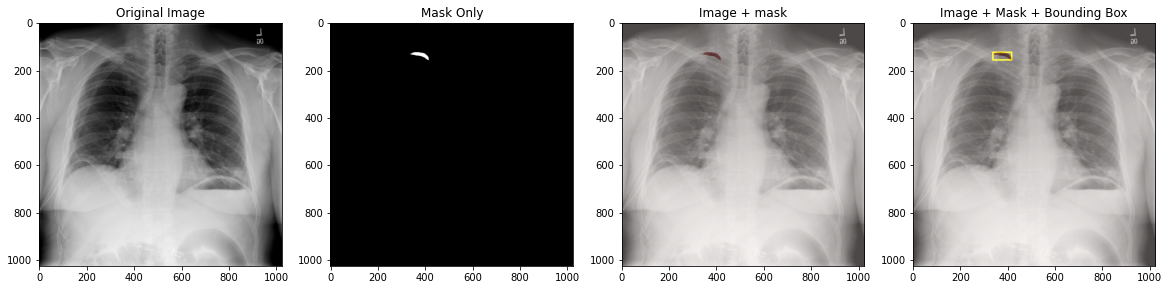

In [52]:
number_of_images_to_plot = 7

train_metadata_df_ill = train_metadata_df[train_metadata_df['Label'] == 'Pneumothorax'].reset_index(drop=True)
partial_ill_uids_list = train_metadata_df_ill.head(number_of_images_to_plot)['UID'].to_list()

plot_imgs(
    uids_list=partial_ill_uids_list, 
    images_df=train_images_df, 
    rle_encodings_df=train_rle_encodings_df,
)

### Location of pneumathorax

In [53]:
%%time
# around ...

# init variables
total_sum = np.zeros((1024,1024))
pa_sum = np.zeros((1024,1024))
ap_sum = np.zeros((1024,1024))

# get data
for item in results:
    total_sum += item['Mask']
    if item['ViewPosition'] == 'PA':
        pa_sum += item['Mask']
    elif item['ViewPosition'] == 'AP':
        ap_sum += item['Mask']
    else:
        pass # problem

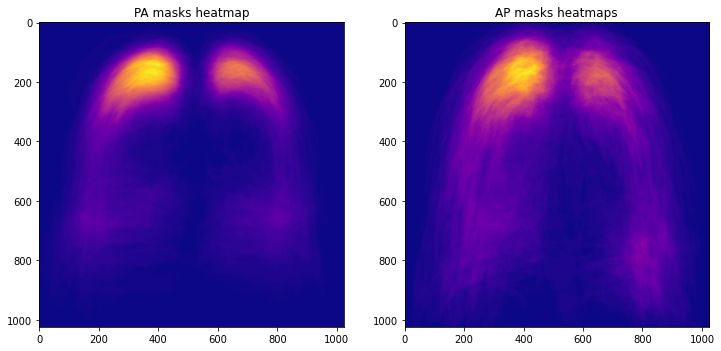

CPU times: user 468 ms, sys: 29.5 ms, total: 497 ms
Wall time: 519 ms


In [66]:
%%time
# Create the figure
fig, axes = plt.subplots(1,2, figsize=(12,12))

# Create the plot for the original image
axes[0].imshow(pa_sum, cmap='plasma')
axes[0].set_title('PA masks heatmap')

# Create the plot for the Pneumathorax mask
axes[1].imshow(ap_sum, cmap='plasma')
axes[1].set_title('AP masks heatmaps')

#
plt.show()

# Note: think about creating an EDA for all the unneccesary XRAY signs inside the images ! do EDA for that !